Sebastian Raschka   
last updated: 02/07/2017  

- Link to the containing GitHub Repository: [https://github.com/rasbt/pattern_classification](https://github.com/rasbt/pattern_classification)
- Link to this IPython Notebook on GitHub: [principal_component_analysis.ipynb]("https://github.com/rasbt/pattern_classification/blob/master/dimensionality_reduction/projection/principal_component_analysis.ipynb")  

<hr>
# Stepping through a Principal Component Analysis
# - using Python's numpy and matplotlib
<hr>

### Sections

- <a href="#introduction">Introduction</a>  
- <a href="#sample_data">Generating 3-dimensional sample data</a>
- <a href="#gen_data">The step by step approach</a>
    - 1.&nbsp;<a href="#drop_labels">Taking the whole dataset ignoring the class labels</a>  
    - 2.&nbsp;<a href="#mean_vec">Compute the $d$-dimensional mean vector</a>
    - 3.&nbsp;<a href="#comp_scatter">Computing the scatter matrix (alternatively, the covariance matrix)</a>
    - 4.&nbsp;<a href="#eig_vec">Computing eigenvectors and corresponding eigenvalues</a>
    - 5.&nbsp;<a href="#sort_eig">Ranking and choosing $k$ eigenvectors</a>
    - 6.&nbsp;<a href="#transform">Transforming the samples onto the new subspace</a>
- <a href="#mat_pca">Using the `PCA()` class from the `matplotlib.mlab` library</a>
    - &nbsp;<a href="#diff_mat_pca">Differences between the step by step approach and matplotlib.mlab.PCA()</a>
- <a href="#sklearn_pca">Using the `PCA()` class from the sklearn.decomposition library to confirm our results</a>    

<br>
<a name="introduction"></a>


# Introduction

The main purposes of a principal component analysis are the analysis of data to identify patterns and finding patterns to reduce the dimensions of the dataset with minimal loss of information.

Here, our desired outcome of the principal component analysis is to project a feature space (our dataset consisting of $n$ $d$-dimensional samples) onto a smaller subspace that represents our data "well". A possible application would be a pattern classification task, where we want to reduce the computational costs and the error of parameter estimation by reducing the number of dimensions of our feature space by extracting a subspace that describes our data "best".

### Principal Component Analysis (PCA) Vs. Multiple Discriminant Analysis (MDA)

Both Multiple Discriminant Analysis (MDA) and Principal Component Analysis (PCA) are linear transformation methods and closely related to each other. In PCA, we are interested to find the directions (components) that maximize the variance in our dataset, where in MDA, we are additionally interested to find the directions that maximize the separation (or discrimination) between different classes (for example, in pattern classification problems where our dataset consists of multiple classes. In contrast two PCA, which ignores the class labels).  
***In other words, via PCA, we are projecting the entire set of data (without class labels) onto a different subspace, and in MDA, we are trying to determine a suitable subspace to distinguish between patterns that belong to different classes. Or, roughly speaking in PCA we are trying to find the axes with maximum variances where the data is most spread (within a class, since PCA treats the whole data set as one class), and in MDA we are additionally maximizing the spread between classes. ***  
In typical pattern recognition problems, a PCA is often followed by an MDA.

#### What is a "good" subspace?
Let's assume that our goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $(k)$-dimensional subspace (where $k\;<\;d$). 
So, how do we know what size we should choose for $k$, and how do we know if we have a feature space that represents our data "well"?  
Later, we will compute eigenvectors (the components) from our data set and collect them in a so-called scatter-matrix (or alternatively calculate them from the covariance matrix). Each of those eigenvectors is associated with an eigenvalue, which tell us about the "length" or "magnitude" of the eigenvectors. If we observe that all the eigenvalues are of very similar magnitude, this is a good indicator that our data is already in a "good" subspace. Or if some of the eigenvalues are much much higher than others, we might be interested in keeping only those eigenvectors with the much larger eigenvalues, since they contain more information about our data distribution. Vice versa, eigenvalues that are close to 0 are less informative and we might consider in dropping those when we construct the new feature subspace.

### Summarizing the PCA approach

Listed below are the 6 general steps for performing a principal component analysis, which we will investigate in the following sections.

1. <a href="#drop_labels"> Take the whole dataset consisting of $d$-dimensional samples ignoring the class labels</a>  
2. <a href="#mean_vec"> Compute the $d$-dimensional mean vector</a> (i.e., the means for every dimension of the whole dataset)
3. <a href="#sc_matrix">Compute the scatter matrix (alternatively, the covariance matrix) of the whole data set</a>
4. <a href="#eig_vec">Compute eigenvectors ($\pmb e_1, \; \pmb e_2, \; ..., \; \pmb e_d $) and corresponding eigenvalues ($\pmb \lambda_1, \; \pmb \lambda_2, \; ..., \; \pmb \lambda_d$)</a>
5. <a href="#sort_eig">Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $d \times k $ dimensional matrix $\pmb W\;$</a>(where every column represents an eigenvector)
6. <a href="#transform">Use this $d \times k $ eigenvector matrix to transform the samples onto the new subspace.</a> This can be summarized by the mathematical equation: $\pmb y = \pmb W^T \times \pmb x$ (where $\pmb x$ is a $d \times 1$-dimensional vector representing one sample, and $\pmb y$ is the transformed $k \times 1$-dimensional sample in the new subspace.)

<br>
<br>
<a name="sample_data"></a>


# Generating some 3-dimensional sample data

For the following example, we will generate 40 3-dimensional samples randomly drawn from a multivariate Gaussian distribution.   
Here, we will assume that the samples stem from two different classes, where one half (i.e., 20) samples of our data set are labeled $\omega_1$ (class 1) and the other half $\omega_2$ (class 2).  

$\pmb{\mu_1} = $
$\begin{bmatrix}0\\0\\0\end{bmatrix}$ 
$\quad\pmb{\mu_2} = $ 
$\begin{bmatrix}1\\1\\1\end{bmatrix}\quad$(sample means)

$\pmb{\Sigma_1} = $
$\begin{bmatrix}1\quad 0\quad 0\\0\quad 1\quad0\\0\quad0\quad1\end{bmatrix}$
$\quad\pmb{\Sigma_2} = $
$\begin{bmatrix}1\quad 0\quad 0\\0\quad 1\quad0\\0\quad0\quad1\end{bmatrix}\quad$ (covariance matrices)

### Why are we chosing a 3-dimensional sample?
The problem of multi-dimensional data is its visualization, which would make it quite tough to follow our example principal component analysis (at least visually). We could also choose a 2-dimensional sample data set for the following examples, but since the goal of the PCA in an "Diminsionality Reduction" application is to drop at least one of the dimensions, I find it more intuitive and visually appealing to start with a 3-dimensional dataset that we reduce to an 2-dimensional dataset by dropping 1 dimension.



In [1]:
import numpy as np

np.random.seed(0)

mu_vec1 = np.array([0, 0, 0])
cov_mat1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
assert class1_sample.shape == (3, 20), "The matrix has not the dimensions 3x20"

mu_vec2 = np.array([1, 1, 1])
cov_mat2 = np.array([[1, 0, 0],[0, 1, 0], [0, 0, 1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class2_sample.shape == (3, 20), "The matrix has not the dimensions 3x20"

Using the code above, we created two $3\times20$ datasets - one dataset for each class $\omega_1$ and $\omega_2$ -  
where each column can be pictured as a 3-dimensional vector $\pmb x = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \end{pmatrix}$ so that our dataset will have the form  
$\pmb X = \begin{pmatrix} x_{1_1}\; x_{1_2} \; ... \; x_{1_{20}}\\ x_{2_1} \; x_{2_2} \; ... \; x_{2_{20}}\\ x_{3_1} \; x_{3_2} \; ... \; x_{3_{20}}\end{pmatrix}$

Just to get a rough idea how the samples of our two classes $\omega_1$ and $\omega_2$ are distributed, let us plot them in a 3D scatter plot.

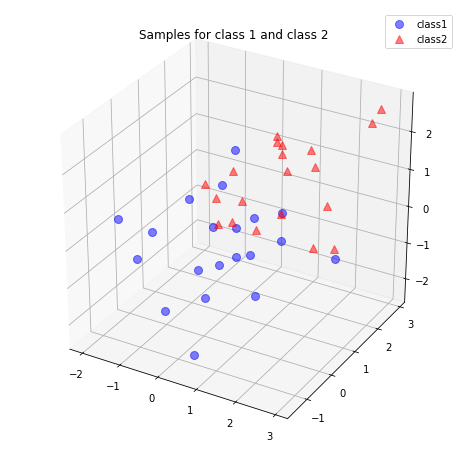

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0, :], class1_sample[1, :], 
        class1_sample[2, :], 'o', markersize=8, 
        color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0, :], class2_sample[1, :], 
        class2_sample[2, :], '^', markersize=8, 
        alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

<br>
<br>
<a name='drop_labels'></a>

# 1. Taking the whole dataset ignoring the class labels

Because we don't need class labels for the PCA analysis, let us merge the samples for our 2 classes into one $3\times40$-dimensional array.

In [3]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3, 40), "The matrix has not the dimensions 3x40"

<br>
<br>
<a name='mean_vec'></a>

# 2. Computing the d-dimensional mean vector

In [4]:
mean_x = np.mean(all_samples[0, :])
mean_y = np.mean(all_samples[1, :])
mean_z = np.mean(all_samples[2, :])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

print('Mean Vector:\n', mean_vector)

Mean Vector:
 [[ 0.69887368]
 [ 0.80019884]
 [ 0.39876272]]


<br>
<br>
<a name="comp_scatter"></a>


# 3. a) Computing the Scatter Matrix

The scatter matrix is computed by the following equation:  
$S = \sum\limits_{k=1}^n (\pmb x_k - \pmb m)\;(\pmb x_k - \pmb m)^T$  
where $\pmb m$ is the mean vector  
$\pmb m = \frac{1}{n} \sum\limits_{k=1}^n \; \pmb x_k$

In [5]:
scatter_matrix = np.zeros((3, 3))
for i in range(all_samples.shape[1]):
    scatter_matrix += (all_samples[:, i].reshape(3, 1)\
                       - mean_vector).dot((all_samples[:, i].reshape(3, 1)
                                           - mean_vector).T)
print('Scatter Matrix:\n', scatter_matrix)

Scatter Matrix:
 [[ 54.75319714  12.1506419   20.98922466]
 [ 12.1506419   53.09745345  18.13107282]
 [ 20.98922466  18.13107282  56.45952312]]


<br>
<br>
<a name="comp_cov"></a>

#3. b) Computing the Covariance Matrix (alternatively to the scatter matrix)
Alternatively, instead of calculating the scatter matrix, we could also calculate the covariance matrix using the in-built `numpy.cov()` function.  The equations for the covariance matrix and scatter matrix are very similar, the only difference is, that we use the scaling factor $\frac{1}{N-1}$ (here: $\frac{1}{40-1} = \frac{1}{39}$) for the covariance matrix. Thus, their ***eigenspaces*** will be identical (identical eigenvectors, only the eigenvalues are scaled differently by a constant factor).



$\Sigma_i = \Bigg[ 
\begin{array}{cc}
\sigma_{11}^2 & \sigma_{12}^2 & \sigma_{13}^2\\
\sigma_{21}^2 & \sigma_{22}^2 & \sigma_{23}^2\\
\sigma_{31}^2 & \sigma_{32}^2 & \sigma_{33}^2\\
\end{array} \Bigg]$

In [6]:
cov_mat = np.cov([all_samples[0, :], 
                  all_samples[1, :], 
                  all_samples[2, :]])
print('Covariance Matrix:\n', cov_mat)

Covariance Matrix:
 [[ 1.40392813  0.31155492  0.53818525]
 [ 0.31155492  1.36147317  0.4648993 ]
 [ 0.53818525  0.4648993   1.44768008]]


<br>
<br>
<a name="eig_vec"></a>

# 4. Computing eigenvectors and corresponding eigenvalues

To show that the eigenvectors are indeed identical whether we derived them from the scatter or the covariance matrix, let us put an `assert` statement into the code. Also, we will see that the eigenvalues were indeed scaled by the factor 39 when we derived it from the scatter matrix.

In [7]:
# eigenvectors and eigenvalues for the from the scatter matrix
eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:, i].reshape(1, 3).T
    eigvec_cov = eig_vec_cov[:,i].reshape(1, 3).T
    assert eigvec_sc.all() == eigvec_cov.all(), 'Eigenvectors are not identical'
    
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from scatter matrix: {}'.format(i+1, eig_val_sc[i]))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('Scaling factor: ', eig_val_sc[i]/eig_val_cov[i])
    print(40 * '-')

Eigenvector 1: 
[[-0.5690384 ]
 [-0.51164745]
 [-0.64374854]]
Eigenvalue 1 from scatter matrix: 89.42331351750256
Eigenvalue 1 from covariance matrix: 2.2929054748077577
Scaling factor:  39.0
----------------------------------------
Eigenvector 2: 
[[-0.62675178]
 [ 0.77664688]
 [-0.06326004]]
Eigenvalue 2 from scatter matrix: 41.81509448386745
Eigenvalue 2 from covariance matrix: 1.072181909842755
Scaling factor:  39.0
----------------------------------------
Eigenvector 3: 
[[-0.53233213]
 [-0.36747315]
 [ 0.76261785]]
Eigenvalue 3 from scatter matrix: 33.07176570647169
Eigenvalue 3 from covariance matrix: 0.8479939924736329
Scaling factor:  39.0
----------------------------------------


### Checking the eigenvector-eigenvalue calculation

Let us quickly check that the eigenvector-eigenvalue calculation is correct and satisfy the equation

$\pmb\Sigma\pmb{v} = \lambda\pmb{v}$  

<br>
where  
$\pmb\Sigma = Covariance \; matrix\\
\pmb{v} = \; Eigenvector\\
\lambda = \; Eigenvalue$

In [8]:
for i in range(len(eig_val_sc)):
    eigv = eig_vec_sc[:, i].reshape(1, 3).T
    np.testing.assert_array_almost_equal(scatter_matrix.dot(eigv), eig_val_sc[i] * eigv, 
                                         decimal=6, err_msg='', verbose=True)

### Visualizing the eigenvectors

And before we move on to the next step, just to satisfy our own curiosity, we plot the eigenvectors centered at the sample mean.

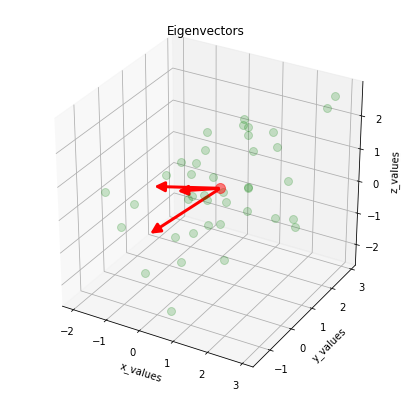

In [9]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0, :], all_samples[1, :], all_samples[2, :], 
        'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 
        'o', markersize=10, color='red', alpha=0.5)

for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], 
                [mean_z, v[2]], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)

ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

<br>
<br>
<a name="sort_eig"></a>

<a name="sort_eig"></a>
<br>
<br>

# 5.1. Sorting the eigenvectors by decreasing eigenvalues
We started with the goal to reduce the dimensionality of our feature space, i.e., projecting the feature space via PCA onto a smaller subspace, where the eigenvectors will form the axes of this new feature subspace. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which we can confirm by the following code:

In [10]:
for ev in eig_vec_sc:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
    # instead of 'assert' because of rounding errors

So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.  
The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top $k$ eigenvectors.

In [11]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), 
              eig_vec_sc[:, i]) for i in range(len(eig_val_sc))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

89.4233135175
41.8150944839
33.0717657065


<br>
<br>


# 5.2. Choosing *k* eigenvectors with the largest eigenvalues
For our simple example, where we are reducing a 3-dimensional feature space to a 2-dimensional feature subspace, we are combining the two eigenvectors with the highest eigenvalues to construct our $d \times k$-dimensional eigenvector matrix $\pmb W$.

In [12]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(3, 1), 
                      eig_pairs[1][1].reshape(3, 1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.5690384  -0.62675178]
 [-0.51164745  0.77664688]
 [-0.64374854 -0.06326004]]


<br>
<br>
<a name='transform'></a>

# 6. Transforming the samples onto the new subspace
In the last step, we use the $2 \times 3$-dimensional matrix $\pmb W$ that we just computed to transform our samples onto the new subspace via the equation  $\pmb y = \pmb W^T \times \pmb x$.

In [13]:
transformed = matrix_w.T.dot(all_samples)
assert transformed.shape == (2, 40), "The matrix is not 2x40 dimensional."

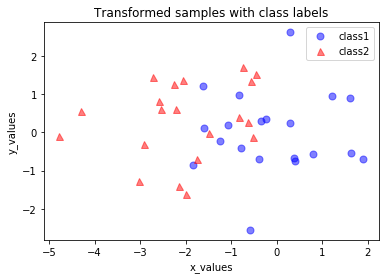

In [14]:
plt.plot(transformed[0, 0:20], transformed[1, 0:20], 
         'o', markersize=7, color='blue', 
         alpha=0.5, label='class1')
plt.plot(transformed[0, 20:40], transformed[1, 20:40], '^', 
         markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()

<br>
<br>
<a name="mat_pca"></a>


# Using the PCA() class from the matplotlib.mlab library

Now, that we have seen how a principal component analysis works, we can use the in-built `PCA()` class from the `matplotlib` library for our convenience in future applications.
Unfortunately, the original documentation ([http://matplotlib.sourceforge.net/api/mlab_api.html#matplotlib.mlab.PCA](http://matplotlib.sourceforge.net/api/mlab_api.html#matplotlib.mlab.PCA)) is very sparse;  
a better documentation can be found here: [https://www.clear.rice.edu/comp130/12spring/pca/pca_docs.shtml](https://www.clear.rice.edu/comp130/12spring/pca/pca_docs.shtml).  

And the original code implementation of the `PCA()` class can be viewed at:  
[https://sourcegraph.com/github.com/matplotlib/matplotlib/symbols/python/lib/matplotlib/mlab/PCA](https://sourcegraph.com/github.com/matplotlib/matplotlib/symbols/python/lib/matplotlib/mlab/PCA)

#### Class attributes of `PCA()`

    Attrs:

    a : a centered unit sigma version of input a

    numrows, numcols: the dimensions of a

    mu : a numdims array of means of a

    sigma : a numdims array of atandard deviation of a

    fracs : the proportion of variance of each of the principal components

    Wt : the weight vector for projecting a numdims point or array into PCA space

    Y : a projected into PCA space

Also, it has to be mentioned that the `PCA()` class expects a `np.array()` as input where: `'we assume data in a is organized with numrows>numcols')`, so that we have to transpose our dataset.  

`matplotlib.mlab.PCA()` keeps all $d$-dimensions of the input dataset after the transformation (stored in the class attribute `PCA.Y`), and assuming that they are already ordered ("Since the PCA analysis orders the PC axes by descending importance in terms of describing the clustering, we see that fracs is a list of monotonically decreasing values.", [https://www.clear.rice.edu/comp130/12spring/pca/pca_docs.shtml](https://www.clear.rice.edu/comp130/12spring/pca/pca_docs.shtml)) we just need to plot the first 2 columns if we are interested in projecting our 3-dimensional input dataset onto a 2-dimensional subspace.

PC axes in terms of the measurement axes scaled by the standard deviations:
 [[-0.5687065  -0.53470094 -0.62503425]
 [ 0.62397375 -0.7755595   0.09572991]
 [ 0.53593812  0.33556274 -0.77470509]]


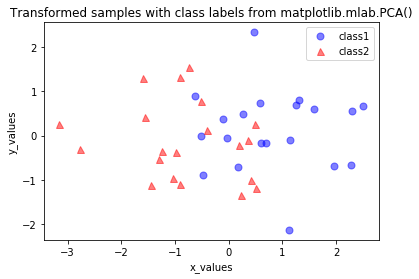

In [15]:
from matplotlib.mlab import PCA as mlabPCA
 
mlab_pca = mlabPCA(all_samples.T) 

print('PC axes in terms of the measurement axes scaled by the standard deviations:\n', mlab_pca.Wt)

plt.plot(mlab_pca.Y[0:20, 0],mlab_pca.Y[0:20, 1], 'o', 
         markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(mlab_pca.Y[20:40, 0], mlab_pca.Y[20:40, 1], '^', 
         markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

plt.show()

<br>
<br>
<a name="_diff_mat_pca"></a>


## Differences between the step by step approach and matplotlib.mlab.PCA()

When we plot the transformed dataset onto the new 2-dimensional subspace, we observe that the scatter plots from our step by step approach and the `matplotlib.mlab.PCA()` class do not look identical. This is due to the fact that `matplotlib.mlab.PCA()` class ***scales the variables to unit variance*** prior to calculating the covariance matrices. This will/could eventually lead to different variances along the axes and affect the contribution of the variable to principal components. 

One example where a scaling would make sense would be if one variable was measured in the unit **inches** where the other variable was measured in **cm**.  
However, for our hypothetical example, we assume that both variables have the same (arbitrary) unit, so that we skipped the step of scaling the input data.

<br>
<br>
<a name="sklearn_pca"> </a>


# Using the PCA() class from the sklearn.decomposition library to confirm our results

In order to make sure that we have not made a mistake in our step by step approach, we will use another library that doesn't rescale the input data by default.  
Here, we will use the PCA class from the `scikit-learn` machine-learning library. The documentation can be found here:  
[http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  

For our convenience, we can directly specify to how many components we want to reduce our input dataset via the `n_components` parameter. 

    n_components : int, None or string
    
    Number of components to keep. if n_components is not set all components are kept:
        n_components == min(n_samples, n_features)
        if n_components == ‘mle’, Minka’s MLE is used to guess the dimension if 0 < n_components < 1, 
        select the number of components such that the amount of variance that needs to be explained 
        is greater than the percentage specified by n_components

Next, we just need to use the `.fit_transform()` in order to perform the dimensionality reduction.

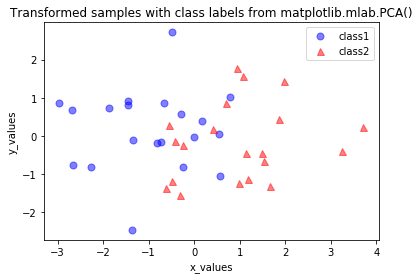

In [16]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(all_samples.T)

plt.plot(sklearn_transf[0:20, 0],sklearn_transf[0:20, 1], 
         'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40, 0], sklearn_transf[20:40, 1], 
         '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.legend()
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

plt.show()

Depending on your computing environmnent, you may find that the plot above is the exact mirror image of the plot from out step by step approach. This is due to the fact that the signs of the eigenvectors can be either positive or negative, since the eigenvectors are scaled to the unit length 1, both we can simply multiply the transformed data by $\times(-1)$ to revert the mirror image.

Please note that this is not an issue: If $v$ is an eigenvector of a matrix $\Sigma$, we have,

$$\Sigma v = \lambda v,$$

where $\lambda$ is our eigenvalue. Then $-v$ is also an eigenvector that has the same eigenvalue, since

$$\Sigma(-v) = -\Sigma v = -\lambda v = \lambda(-v).$$

Also, see the note in the scikit-learn documentation:

> Due to implementation subtleties of the Singular Value Decomposition (SVD), which is used in this implementation, running fit twice on the same matrix can lead to principal components with signs flipped (change in direction). For this reason, it is important to always use the same estimator object to transform data in a consistent fashion.

(http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

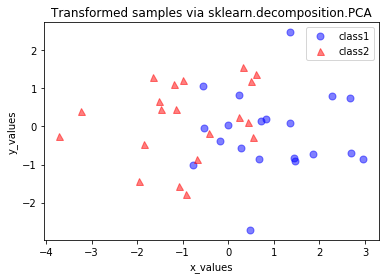

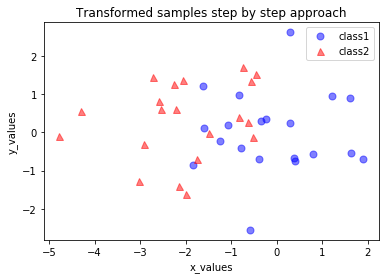

In [17]:
# sklearn.decomposition.PCA

sklearn_transf *= (-1) 

plt.plot(sklearn_transf[0:20, 0], sklearn_transf[0:20, 1] , 'o', 
         markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40, 0], sklearn_transf[20:40, 1] , '^',
         markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples via sklearn.decomposition.PCA')
plt.show()

# step by step PCA
plt.plot(transformed[0, 0:20], transformed[1, 0:20], 
         'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0, 20:40], transformed[1, 20:40], 
         '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples step by step approach')
plt.show()

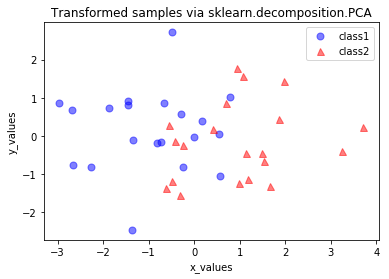

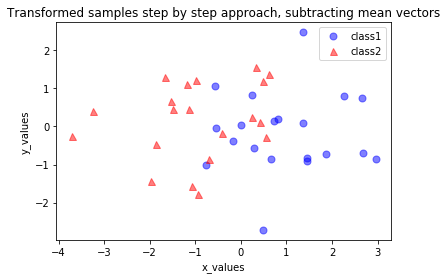

In [18]:
# sklearn.decomposition.PCA

sklearn_transf *= (-1) 

plt.plot(sklearn_transf[0:20, 0], sklearn_transf[0:20, 1] , 'o', 
         markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40, 0], sklearn_transf[20:40, 1] , '^',
         markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples via sklearn.decomposition.PCA')
plt.show()

# step by step PCA

transformed = matrix_w.T.dot(all_samples - mean_vector)

plt.plot(transformed[0, 0:20], transformed[1, 0:20], 
         'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0, 20:40], transformed[1, 20:40], 
         '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples step by step approach, subtracting mean vectors')
plt.show()

In [ ]:
tested; Gopal